In [1]:
### Unzip the kaggle dataset
import zipfile

zipfile_path = 'archive.zip'
extract_dir = 'data'

with zipfile.ZipFile(zipfile_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print('File extracted to: ',extract_dir)

File extracted to:  data


# Import modules

In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
import tensorflow as tf
from IPython.display import Audio
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

# Load data

In [62]:
root_dir = 'data/TESS Toronto emotional speech set data'

paths = []
labels = []

for subdir, dirs, files in os.walk(root_dir):
    for file in files:
        if file.endswith('.wav'):
            file_path = os.path.join(subdir, file)
            paths.append(file_path)
            label = file.split('_')[-1]
            label = label.split('.')[0]
            labels.append(label.lower())

print(f'Total speech files found: {len(paths)}')
print('Sample files:', file)

Total speech files found: 2800
Sample files: YAF_youth_sad.wav


In [63]:
paths[:5]

['data/TESS Toronto emotional speech set data\\OAF_angry\\OAF_back_angry.wav',
 'data/TESS Toronto emotional speech set data\\OAF_angry\\OAF_bar_angry.wav',
 'data/TESS Toronto emotional speech set data\\OAF_angry\\OAF_base_angry.wav',
 'data/TESS Toronto emotional speech set data\\OAF_angry\\OAF_bath_angry.wav',
 'data/TESS Toronto emotional speech set data\\OAF_angry\\OAF_bean_angry.wav']

In [64]:
labels[:5]

['angry', 'angry', 'angry', 'angry', 'angry']

# Create dataframe

In [65]:
df = pd.DataFrame()
df['speech'] = paths
df['label'] = labels

df.head(5)

,speech,label
0,data/TESS Toronto emotional speech set data\OA...,angry
1,data/TESS Toronto emotional speech set data\OA...,angry
2,data/TESS Toronto emotional speech set data\OA...,angry
3,data/TESS Toronto emotional speech set data\OA...,angry
4,data/TESS Toronto emotional speech set data\OA...,angry


In [66]:
df['label'].value_counts()

label
angry      400
disgust    400
fear       400
happy      400
neutral    400
ps         400
sad        400
Name: count, dtype: int64

In [67]:
df.shape

(2800, 2)

# Perform EDA

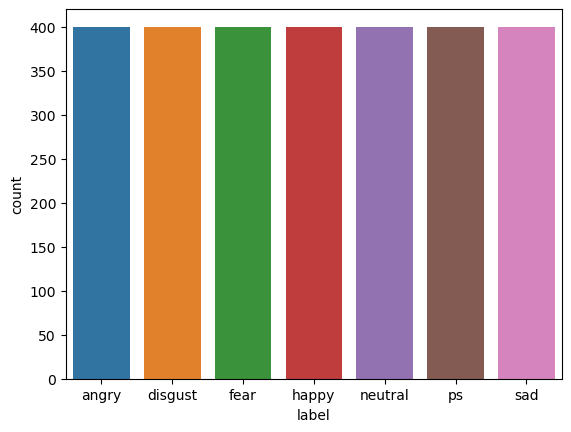

In [68]:
df['label'] = df['label'].astype('category')

sns.countplot(x='label', data=df)
plt.show()

In [69]:
def waveplot(data, sample_rate, emotion):
    plt.figure(figsize=(10,4))
    plt.title(emotion, size=20)
    librosa.display.waveshow(data, sr=sample_rate)
    plt.show()

def spectogram(data, sample_rate, emotion):
    x = librosa.stft(data)
    xdb = librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(11,4))
    plt.title(emotion, size=20)
    librosa.display.specshow(xdb, sr=sample_rate, x_axis='time', y_axis='hz')
    plt.colorbar()

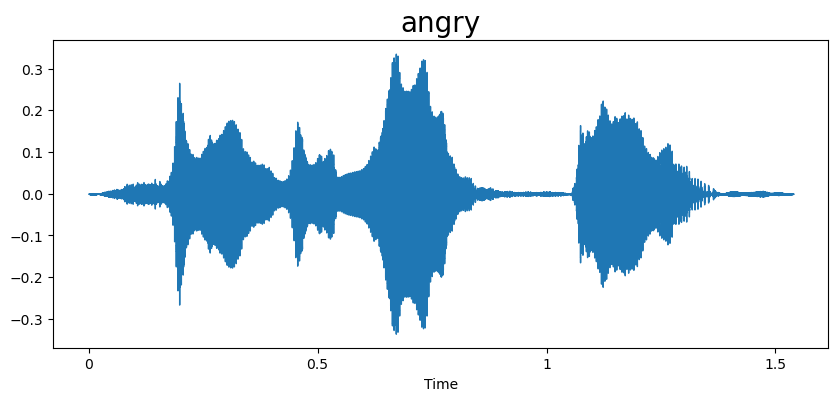

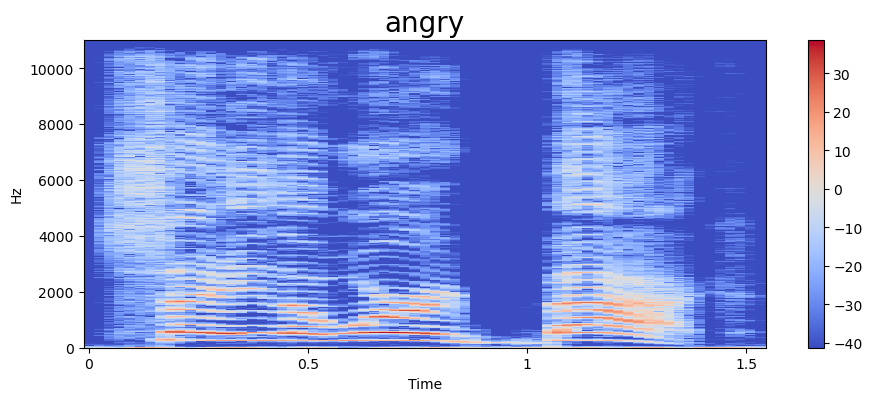

In [70]:
emotion = 'angry'
path = df['speech'][df['label']==emotion].iloc[0]
data, sample_rate = librosa.load(path)
waveplot(data, sample_rate, emotion)
spectogram(data, sample_rate, emotion)
Audio(path)

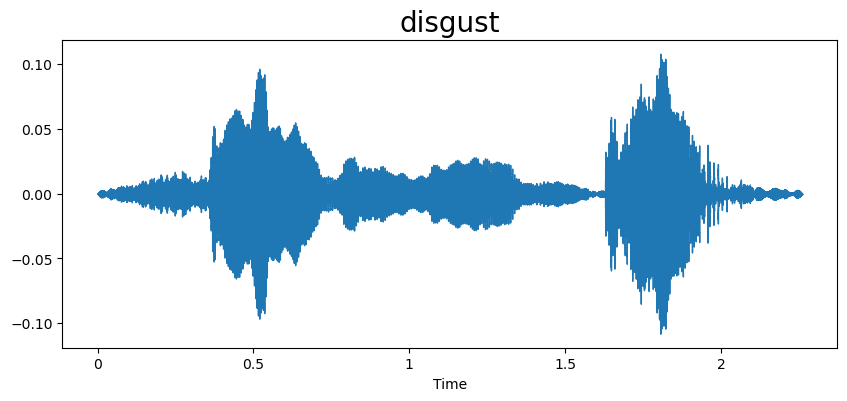

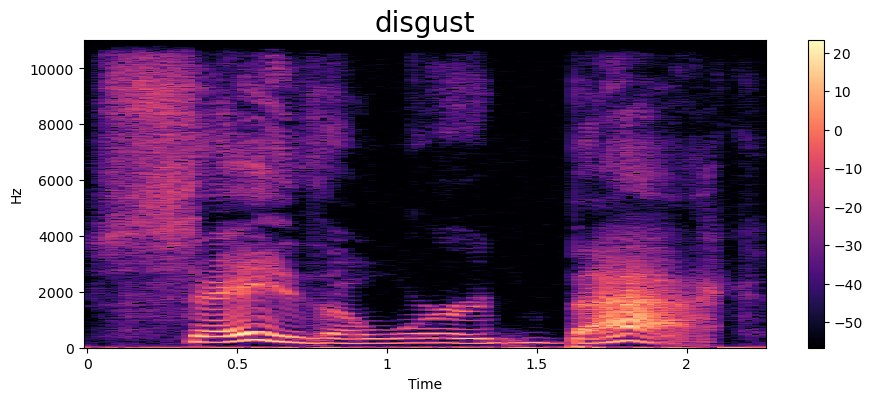

In [71]:
emotion = 'disgust'
path = df['speech'][df['label']==emotion].iloc[0]
data, sample_rate = librosa.load(path)
waveplot(data, sample_rate, emotion)
spectogram(data, sample_rate, emotion)
Audio(path)

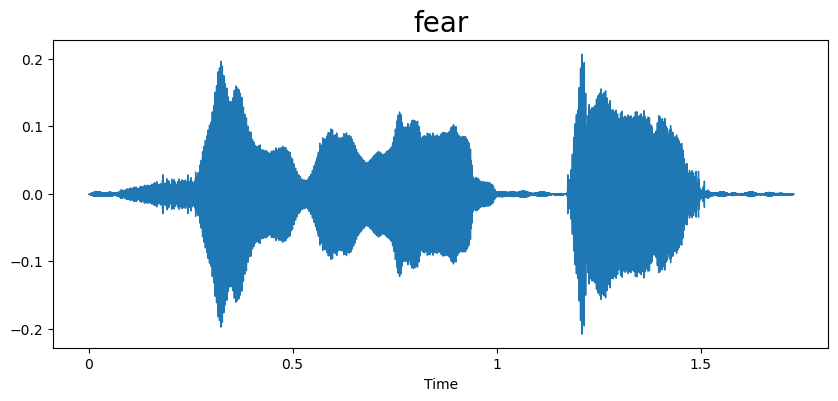

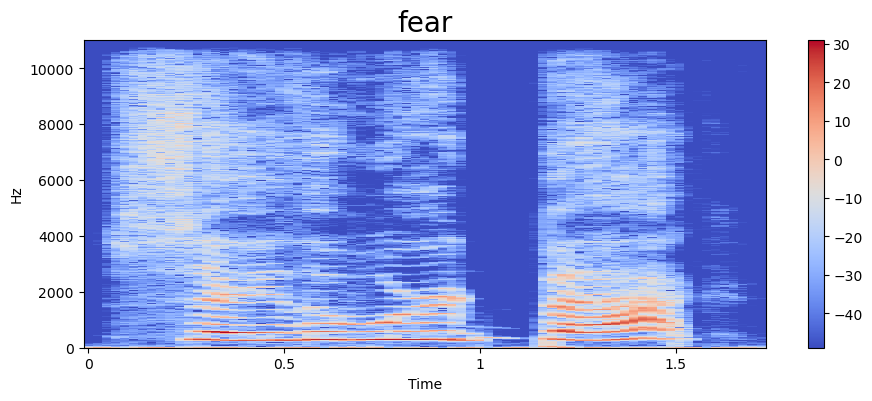

In [72]:
emotion = 'fear'
path = df['speech'][df['label']==emotion].iloc[0]
data, sample_rate = librosa.load(path)
waveplot(data, sample_rate, emotion)
spectogram(data, sample_rate, emotion)
Audio(path)

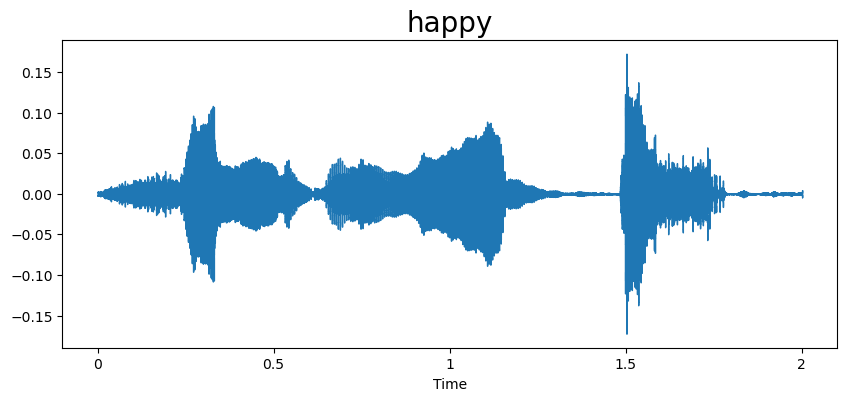

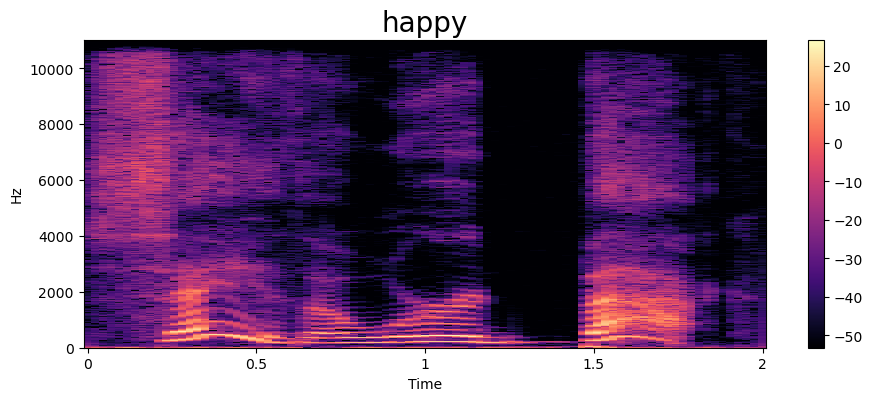

In [73]:
emotion = 'happy'
path = df['speech'][df['label']==emotion].iloc[0]
data, sample_rate = librosa.load(path)
waveplot(data, sample_rate, emotion)
spectogram(data, sample_rate, emotion)
Audio(path)

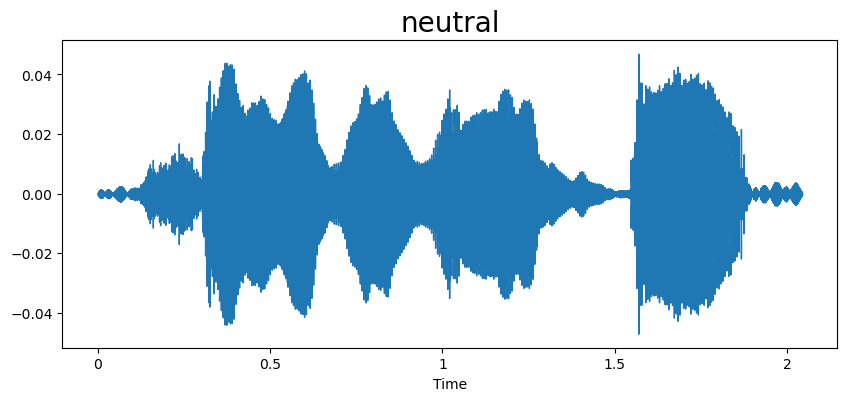

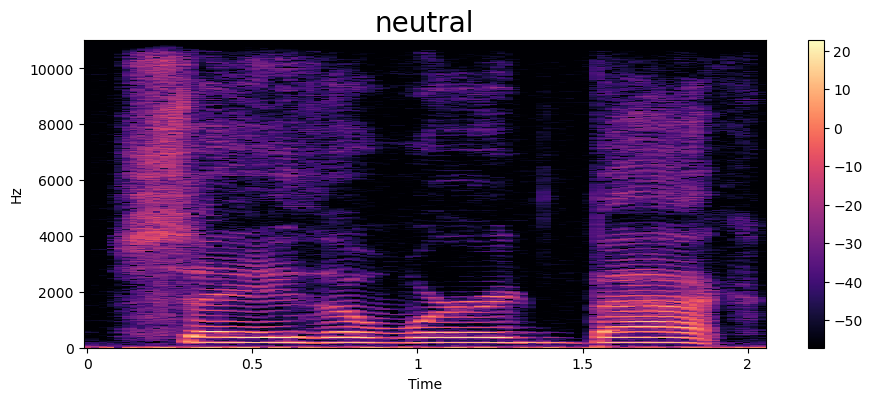

In [74]:
emotion = 'neutral'
path = df['speech'][df['label']==emotion].iloc[0]
data, sample_rate = librosa.load(path)
waveplot(data, sample_rate, emotion)
spectogram(data, sample_rate, emotion)
Audio(path)

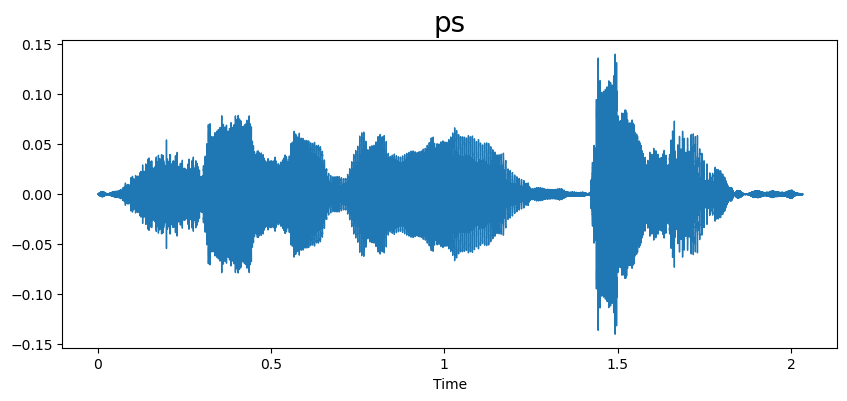

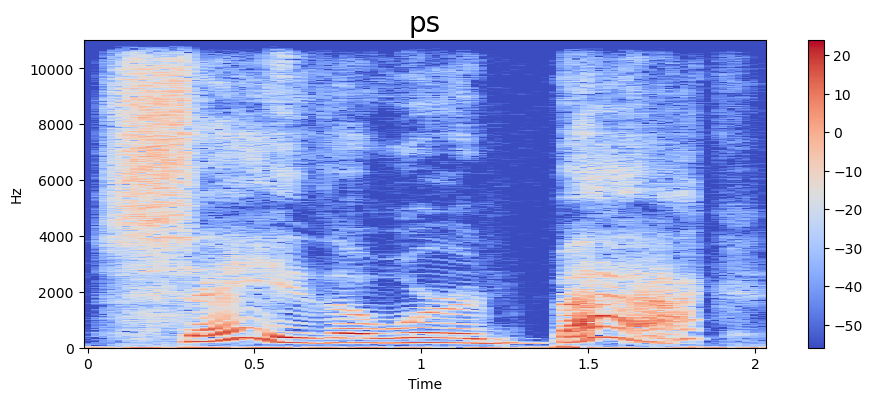

In [75]:
emotion = 'ps'
path = df['speech'][df['label']==emotion].iloc[0]
data, sample_rate = librosa.load(path)
waveplot(data, sample_rate, emotion)
spectogram(data, sample_rate, emotion)
Audio(path)

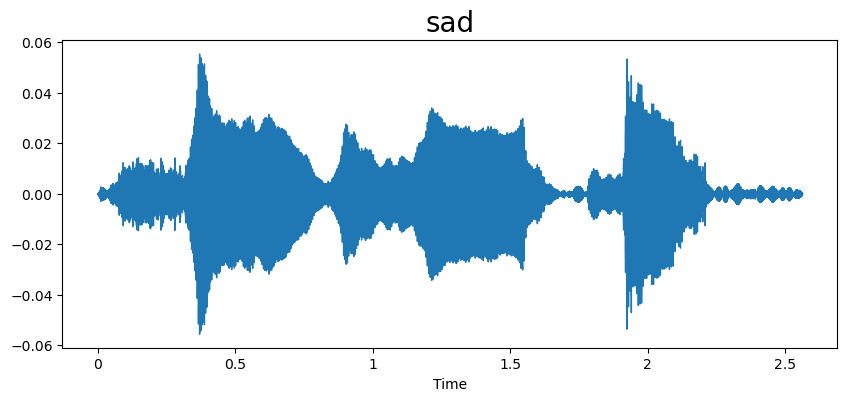

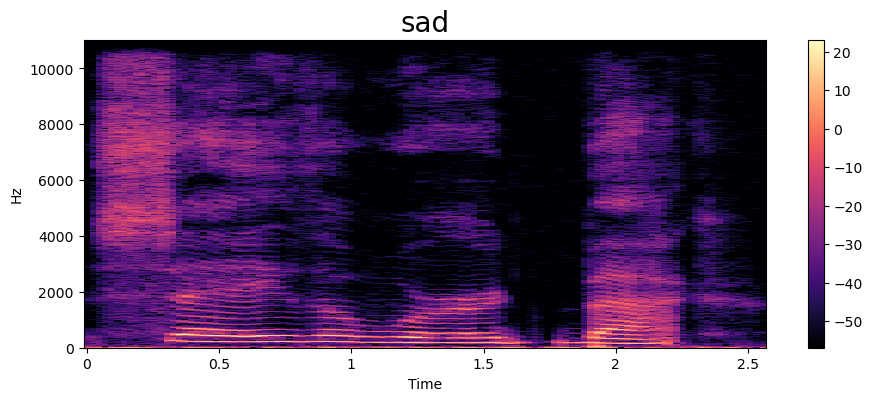

In [76]:
emotion = 'sad'
path = df['speech'][df['label']==emotion].iloc[0]
data, sample_rate = librosa.load(path)
waveplot(data, sample_rate, emotion)
spectogram(data, sample_rate, emotion)
Audio(path)

# Feature Extraction

In [77]:
def extract_mfcc(filename):
    y, sampling_rate = librosa.load(filename, duration=3, offset=0.5)
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sampling_rate, n_mfcc=40).T, axis=0)
    return mfcc

In [78]:
### For a single audio file
extract_mfcc(df['speech'][0])

array([-3.9698621e+02,  7.7440536e+01, -1.9592791e+01, -2.1666689e+01,
       -2.1127560e+00,  1.0075363e+01, -2.0366707e+01, -6.0924492e+00,
       -7.2122831e+00, -5.5736607e-01, -1.8325531e+00,  2.0210162e-01,
        7.2755075e-01,  1.3177377e+00,  2.8863375e+00,  2.8557906e+00,
       -4.7129216e+00, -4.4365110e+00, -1.6211592e+00, -1.0239839e+01,
       -7.5512629e+00, -1.7968802e+00, -7.0376525e+00,  9.4365835e+00,
        8.3558550e+00,  2.1712360e+01,  1.9216991e+01,  2.0348930e+01,
        1.3413366e+01,  8.3391724e+00,  3.9472228e-01,  5.1113148e+00,
        9.5687389e+00,  5.4548678e+00,  2.5099635e+00, -1.8239073e+00,
        4.8689618e+00,  9.3139229e+00,  2.0891502e+00, -1.9064913e+00],
      dtype=float32)

In [79]:
x_mfcc = df['speech'].apply(lambda x: extract_mfcc(x))

In [80]:
x_mfcc

0       [-396.9862, 77.44054, -19.59279, -21.666689, -...
1       [-465.73267, 98.77373, 0.65600866, -32.74544, ...
2       [-429.79196, 46.12401, 1.5550478, -0.21709459,...
3       [-403.46118, 76.32369, -12.531775, -22.288858,...
4       [-434.05756, 77.4455, 10.8655, 16.092943, 8.04...
                              ...                        
2795    [-406.48053, 80.379875, 32.462395, 46.579094, ...
2796    [-426.90918, 102.54756, 24.800041, 43.048096, ...
2797    [-378.50494, 80.91062, 35.300533, 39.74792, -4...
2798    [-434.8618, 89.906364, 28.373262, 39.57707, -2...
2799    [-421.8341, 70.69788, 32.476387, 45.642555, 4....
Name: speech, Length: 2800, dtype: object

In [81]:
X = [x for x in x_mfcc]
X = np.array(X)
X.shape

(2800, 40)

In [82]:
### Input Split
x = np.expand_dims(X, -1)
x.shape

(2800, 40, 1)

In [101]:
enc = OneHotEncoder()
y = enc.fit_transform(df[['label']])
y = y.toarray()

In [102]:
y.shape

(2800, 7)

# Create the LSTM Model

In [125]:
model = Sequential([
    LSTM(256, return_sequences=False, input_shape=(40, 1)),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(7, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                        │ (None, 256)                 │         264,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 7)                   │             455 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 305,799 (1.17 MB)

 Trainable params: 305,799 (1.17 MB)

 Non-trainable params: 0 (0.00 B)

In [126]:
name = 'Speech_emotion_model.keras'

checkpoint = ModelCheckpoint(
    filepath = name,
    save_best_only = True,
    monitor = 'val_loss',
    verbose = 1,
    mode = 'min'
)

# Callback for early stopping
earlystop = EarlyStopping(
    monitor = 'val_loss',
    min_delta = 0,
    patience = 3,
    verbose = 1,
    restore_best_weights = True
)

callbacks = [checkpoint,earlystop]

In [127]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2)

In [128]:
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100, batch_size=64, callbacks=callbacks)

Epoch 1/100
34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.3627 - loss: 1.6215
Epoch 1: val_loss improved from inf to 0.49320, saving model to Speech_emotion_model.keras
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.3708 - loss: 1.6014 - val_accuracy: 0.8339 - val_loss: 0.4932
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.7735 - loss: 0.5808
Epoch 2: val_loss improved from 0.49320 to 0.39227, saving model to Speech_emotion_model.keras
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.7744 - loss: 0.5792 - val_accuracy: 0.8679 - val_loss: 0.3923
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.8887 - loss: 0.3260
Epoch 3: val_loss improved from 0.39227 to 0.16834, saving model to Speech_emotion_model.keras
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.8891 - loss: 0.3246 - val_accuracy: 0.9339 - val_loss: 0.1683
Epoch 4/100
34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9266 - loss: 0.2308
Epoch 4: val_loss did not i

# Plot the results

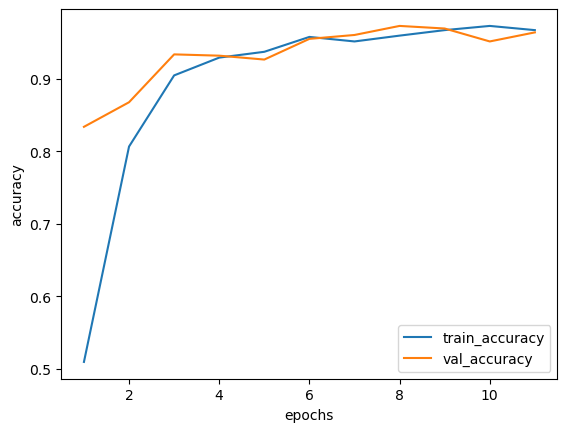

In [132]:
epochs = range(1, len(acc) + 1)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, label='train_accuracy')
plt.plot(epochs, val_acc, label='val_accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

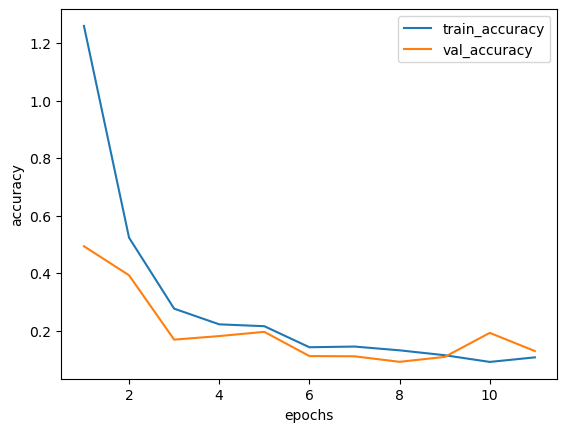

In [133]:
epochs = range(1, len(acc) + 1)
acc = history.history['loss']
val_acc = history.history['val_loss']

plt.plot(epochs, acc, label='train_accuracy')
plt.plot(epochs, val_acc, label='val_accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [154]:
import numpy as np
import librosa
import soundfile as sf
import sounddevice as sd
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical

# Load the saved model
model = load_model('Speech_emotion_model.keras')

# Define sample rate
RATE = 16000

def record_audio(duration=5):
    """Record audio from the microphone for a specified duration."""
    print("Recording...")
    audio_data = sd.rec(int(duration * RATE), samplerate=RATE, channels=1, dtype='float32')
    sd.wait()  # Wait until recording is finished
    return audio_data.flatten()  # Flatten the array to 1D

def preprocess_audio(audio_data):
    """Preprocess audio data and extract MFCC features."""
    # Save audio data to a temporary file
    sf.write('temp.wav', audio_data, RATE)

    # Load and preprocess the audio file
    y, sr = librosa.load('temp.wav', sr=RATE)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)  # 13 MFCC features

    # Ensure the input shape matches what the model expects
    time_steps = 40  # Number of time steps expected by the model

    # Padding or truncating features to match time_steps
    if mfccs.shape[1] < time_steps:
        mfccs = np.pad(mfccs, ((0, 0), (0, time_steps - mfccs.shape[1])), mode='constant')
    elif mfccs.shape[1] > time_steps:
        mfccs = mfccs[:, :time_steps]

    # Reshape MFCC features to match model input shape
    mfccs = mfccs[:, :, np.newaxis]  # Add a new axis to match (40, 1) shape

    return mfccs

emotions = ['happy', 'sad', 'angry', 'neutral', 'fearful', 'disgusted', 'surprised']  # Example labels

def predict_emotion(audio_data):
    """Predict emotion from audio data."""
    mfccs = preprocess_audio(audio_data)
    predictions = model.predict(mfccs)
    emotion_index = np.argmax(predictions[0])  # Get the index of the highest probability
    emotion = emotions[emotion_index]
    return emotion

if __name__ == "__main__":
    audio_data = record_audio()
    emotion = predict_emotion(audio_data)
    print(f"Detected Emotion: {emotion}")

Recording...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
Detected Emotion: neutral


In [5]:
import numpy as np
import librosa
from tensorflow.keras.models import load_model

# Load your trained LSTM model
model = load_model('Speech_emotion_model.keras')

# Function to extract features from the audio file
def extract_features(audio_path, sr=22050):
    audio, sample_rate = librosa.load(audio_path, sr=sr)
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_mean = np.mean(mfccs.T, axis=0)
    return mfccs_mean

# Function to make a prediction on an audio file
def predict_emotion(audio_path):
    features = extract_features(audio_path)
    features = features.reshape(1, -1)
    prediction = model.predict(features)
    
    # Debugging: Print the prediction output
    print(f"Model raw output: {prediction}")
    
    predicted_emotion_index = np.argmax(prediction)
    
    # Ensure the labels match your model's output
    emotion_labels = ['happy', 'sad', 'angry', 'neutral', 'fearful', 'disgusted', 'surprised']  # Adjust this list according to your model
    
    # Debugging: Check if the index is within the bounds of the list
    if predicted_emotion_index < len(emotion_labels):
        predicted_emotion = emotion_labels[predicted_emotion_index]
    else:
        predicted_emotion = "Unknown"  # Handle out-of-range errors
    
    return predicted_emotion

# Test the model with an audio file
audio_path = '03-01-07-01-01-01-19.wav'
predicted_emotion = predict_emotion(audio_path)

print(f'Predicted emotion: {predicted_emotion}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step
Model raw output: [[1.2063902e-03 9.8563933e-01 3.7000250e-04 1.7589931e-03 7.9231610e-04
  4.0404093e-03 6.1926241e-03]]
Predicted emotion: sad
